# 5.8 Практическая работа

## Цели практической работы

* Научиться применять fine-tuning и transfer learning для решения ML-задач.
  В практической работе вы будете использовать эти техники для классификации автомобилей на десять классов по их изображениям.
* Оценить эффективность различных архитектур и гиперпараметров модели.


## Что нужно сделать
* Загрузите и предобработайте датасет.
* Постройте и обучите модели.
* Оцените качество модели по метрике F1.


## Что оценивается
* Построена базовая модель классификации без применения технологий fine-tuning и transfer learning. Посчитана метрика F1.
* Построена модель с помощью уже предобученной модели для решения задачи классификации автомобилей. Посчитана метрика F1.
* Результат с помощью предобученной модели выдаёт качество не менее 70%.




### 1. Загрузка и изучение данных


In [2]:
import os

def check_dataset_structure(base_path):
    print(f"--- Analyzing: {base_path} ---")
    for root, dirs, files in os.walk(base_path):
        # Смотрим только на первый уровень вложенности для краткости
        level = root.replace(base_path, '').count(os.sep)
        if level <= 1:
            indent = ' ' * 4 * level
            print(f"{indent}[{os.path.basename(root)}] - Files: {len(files)}")

# Проверяем структуру по твоим путям
train_path = '/kaggle/input/datasets/aivauzun/data-lake/train/train'
test_path = '/kaggle/input/datasets/aivauzun/data-lake/test/test_upload'

check_dataset_structure(train_path)
check_dataset_structure(test_path)

--- Analyzing: /kaggle/input/datasets/aivauzun/data-lake/train/train ---
[train] - Files: 0
    [7] - Files: 1207
    [2] - Files: 1458
    [5] - Files: 1631
    [8] - Files: 1765
    [0] - Files: 1613
    [3] - Files: 1528
    [1] - Files: 1971
    [4] - Files: 1400
    [9] - Files: 1255
    [6] - Files: 1733
--- Analyzing: /kaggle/input/datasets/aivauzun/data-lake/test/test_upload ---
[test_upload] - Files: 6675


Имеем 10 классов (0, 9). Изображений по классам примерно одинаковое.
Выведем для примера несколько изображений.


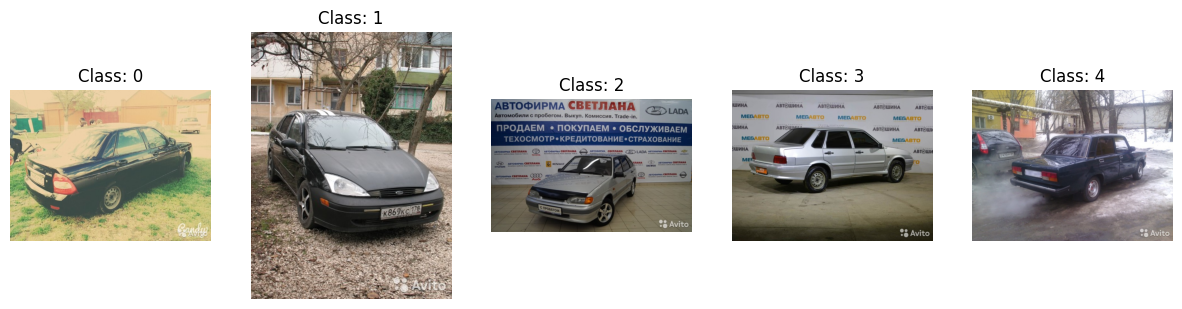

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

# Визуализация примеров
def show_examples(root_path, classes, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, cls in enumerate(classes[:num_images]):
        cls_path = os.path.join(root_path, cls)
        img_name = os.listdir(cls_path)[0]
        img = Image.open(os.path.join(cls_path, img_name))
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Class: {cls}")
        plt.axis('off')
    plt.show()

train_path = '/kaggle/input/datasets/aivauzun/data-lake/train/train'
classes = sorted(os.listdir(train_path))
show_examples(train_path, classes)

Еще один вариант с указанием разрешения

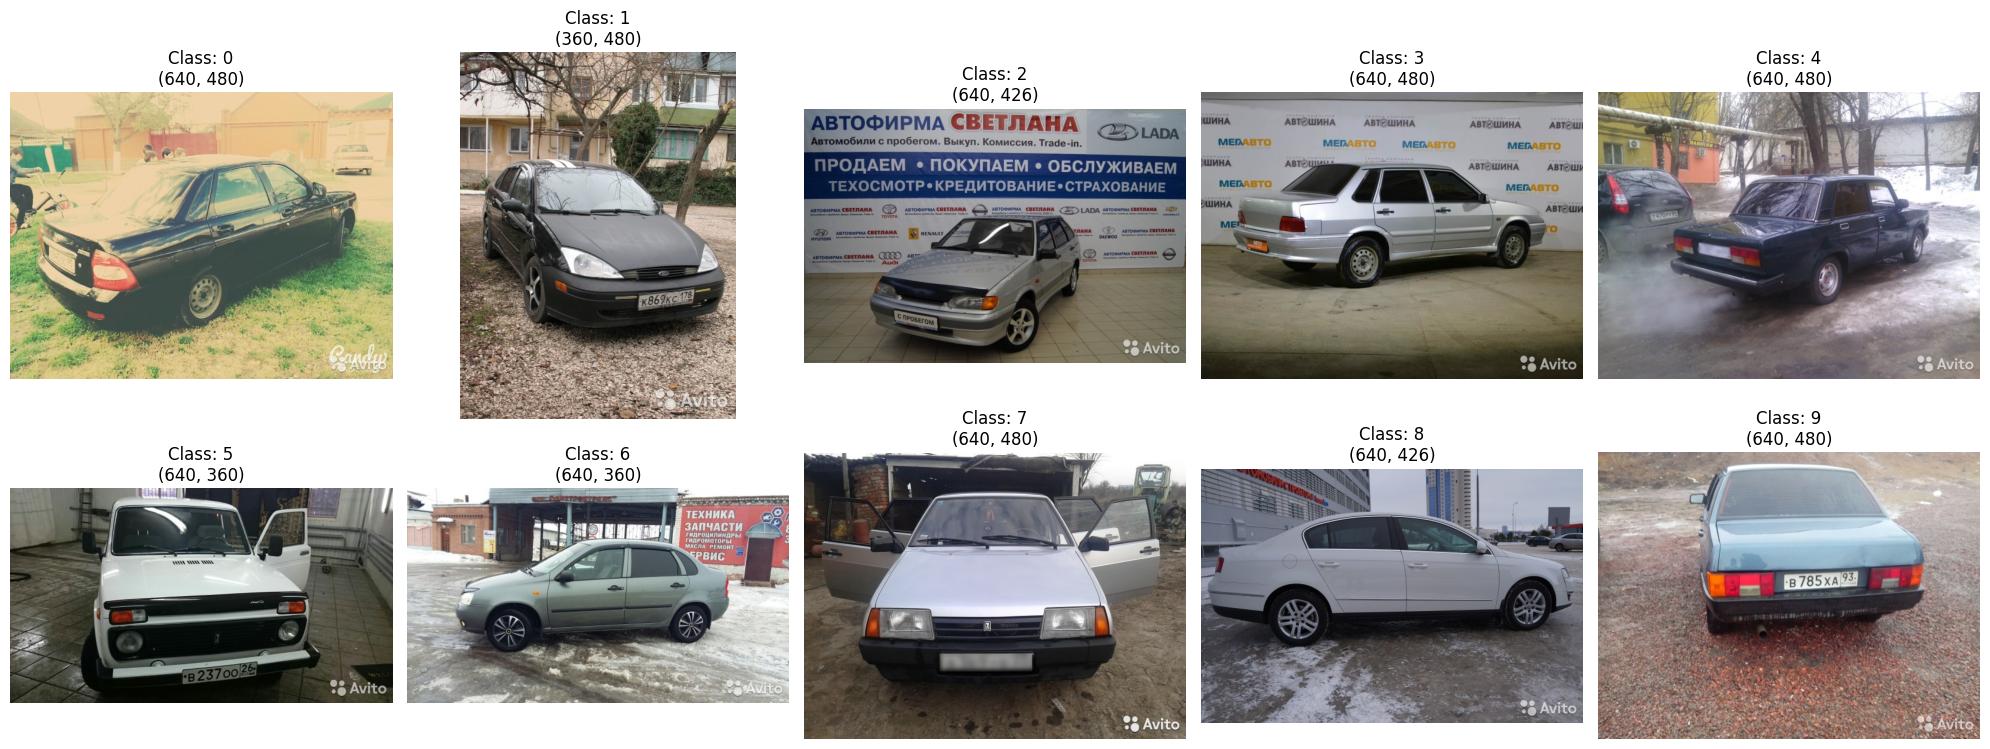

In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Визуализация примеров из каждого класса
def visualize_classes(base_path):
    classes = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for i, cls in enumerate(classes):
        cls_dir = os.path.join(base_path, cls)
        img_name = os.listdir(cls_dir)[0]
        img_path = os.path.join(cls_dir, img_name)
        
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {cls}\n{img.size}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

train_dir = '/kaggle/input/datasets/aivauzun/data-lake/train/train'
visualize_classes(train_dir)

In [5]:
from collections import Counter
from tqdm import tqdm

# Сбор статистики по размерам изображений
def get_image_size_stats(root_path):
    sizes = []
    classes = sorted([d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))])
    
    for cls in classes:
        cls_dir = os.path.join(root_path, cls)
        files = os.listdir(cls_dir)
        for f in files:
            img_path = os.path.join(cls_dir, f)
            try:
                with Image.open(img_path) as img:
                    sizes.append(img.size)
            except:
                continue
                
    size_counts = Counter(sizes)
    return size_counts

train_dir = '/kaggle/input/datasets/aivauzun/data-lake/train/train'
stats = get_image_size_stats(train_dir)

# Вывод топ-10 самых частых размеров
print(f"{'Size (W, H)':<20} | {'Count':<10}")
print("-" * 35)
for size, count in stats.most_common(10):
    print(f"{str(size):<20} | {count:<10}")

print(f"\nTotal unique sizes: {len(stats)}")

Size (W, H)          | Count     
-----------------------------------
(640, 480)           | 7843      
(640, 360)           | 2688      
(360, 480)           | 995       
(640, 427)           | 550       
(640, 384)           | 400       
(640, 478)           | 324       
(270, 480)           | 211       
(640, 477)           | 181       
(640, 361)           | 179       
(604, 453)           | 177       

Total unique sizes: 480


### Наблюдения после вывода:

* **Размеры (img.size):** Если они сильно варьируются, нам критически важен `Resize` перед подачей в тензор.
* **Ракурсы:** Если машины сняты с разных сторон, добавим `RandomHorizontalFlip` в тренировочный пайплайн.
* **Цвета:** Если освещение разное, может пригодиться `ColorJitter`.

Учитывая, что стандартный вход для большинства архитектур `(ResNet, VGG, MobileNet)` — это 224x224, мы можем смело использовать этот размер. Чтобы не искажать пропорции машин при сильном сжатии, лучше использовать `Resize` с сохранением пропорций и последующий `CenterCrop`.


In [6]:
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split

# Оптимальные трансформации для baseline
# Используем CenterCrop, чтобы минимизировать искажения кузова
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Инициализируем датасет
full_dataset = datasets.ImageFolder(root='/kaggle/input/datasets/aivauzun/data-lake/train/train', transform=transform)

# Разбиение на Train и Val (фиксируем random_state для воспроизводимости)
train_idx, val_idx = train_test_split(
    list(range(len(full_dataset))),
    test_size=0.2,
    random_state=42,
    stratify=full_dataset.targets # Сохраняем баланс классов
)

train_data = Subset(full_dataset, train_idx)
val_data = Subset(full_dataset, val_idx)

# Создаем загрузчики
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)

print(f"Train size: {len(train_data)}")
print(f"Val size: {len(val_data)}")
print(f"Classes: {full_dataset.classes}")

Train size: 12448
Val size: 3113
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


### Шаг 1: Baseline. 

Напишем классическую CNN средней глубины. Она будет служить точкой отсчета, чтобы показать, почему для таких задач Transfer Learning — это стандарт индустрии.

#### Aрхитектура:

1. **BatchNorm:** Помогает стабилизировать обучение и быстрее сходиться, особенно когда учим "с нуля".
2. **Dropout:** Защищаем Baseline от быстрого переобучения на специфических деталях фона.
3. **3 сверточных слоя:** Достаточно, чтобы выучить базовые формы (колеса, фары, силуэт), но недостаточно для глубокого понимания марок авто.


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Baseline модель
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(BaselineCNN, self).__init__()
        # Первый блок: из 3 каналов в 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        
        # Второй блок: из 16 в 32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        # Третий блок: из 32 в 64
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # После 3 пулингов 224x224 -> 112 -> 56 -> 28
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1) # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_baseline = BaselineCNN(num_classes=10).to(device)

* Adam Optimizer: Стандарт де-факто для быстрой сходимости.

* CrossEntropyLoss: Оптимальный выбор для многоклассовой классификации.

* f1_score(average='weighted'): Рассчитывает F1 для каждого класса и находит их среднее значение, взвешенное по количеству примеров в каждом классе.

In [8]:
import torch.optim as optim
from sklearn.metrics import f1_score

# Функция обучения и валидации
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'val_f1': []}
    
    for epoch in range(epochs):
        # Режим обучения
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Режим валидации
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Считаем метрику F1 (weighted учитывает дисбаланс, если он есть)
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_loss = running_loss / len(train_loader)
        
        history['train_loss'].append(avg_loss)
        history['val_f1'].append(epoch_f1)
        
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | Val F1: {epoch_f1:.4f}")
    
    return history

# Запуск обучения Baseline
print("--- Training Baseline Model ---")
baseline_history = train_model(model_baseline, train_loader, val_loader, epochs=5)

--- Training Baseline Model ---
Epoch [1/5] | Loss: 2.5986 | Val F1: 0.0284
Epoch [2/5] | Loss: 2.2951 | Val F1: 0.0284
Epoch [3/5] | Loss: 2.2931 | Val F1: 0.0284
Epoch [4/5] | Loss: 2.2926 | Val F1: 0.0284
Epoch [5/5] | Loss: 2.2924 | Val F1: 0.0284


### Шаг 2: Transfer Learning (ResNet50)

Мы используем веса, обученные на ImageNet. На первом этапе заморозим все слои, кроме последнего (классификатора), чтобы адаптировать модель под наши 10 классов.

In [9]:
from torchvision.models import resnet50, ResNet50_Weights

# Загружаем предобученную модель
model_resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Замораживаем веса всех слоев
for param in model_resnet.parameters():
    param.requires_grad = False

# Заменяем финальный полносвязный слой (FC)
# В ResNet50 вход в FC слой имеет 2048 признаков
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 10)

model_resnet = model_resnet.to(device)

# Для Transfer Learning используем чуть меньший LR, чтобы не "сломать" веса классификатора
print("--- Training ResNet50 (Transfer Learning) ---")
resnet_history = train_model(model_resnet, train_loader, val_loader, epochs=5, lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


--- Training ResNet50 (Transfer Learning) ---
Epoch [1/5] | Loss: 1.4109 | Val F1: 0.6233
Epoch [2/5] | Loss: 1.0463 | Val F1: 0.6536
Epoch [3/5] | Loss: 0.9436 | Val F1: 0.6693
Epoch [4/5] | Loss: 0.9028 | Val F1: 0.6583
Epoch [5/5] | Loss: 0.8552 | Val F1: 0.6701


### Шаг 3: Fine-tuning

* Мы разморозим последние два блока ResNet. Это позволит модели лучше различать тонкие детали марок, сохраняя при этом общие знания о визуальном мире.

* Важно: При Fine-tuning мы обязаны снизить Learning Rate (обычно в 10 раз), чтобы не разрушить уже обученные веса резкими градиентами.

* Специализация: Первые слои CNN обычно ищут линии и углы, а последние — сложные объекты. Разморозка последних блоков позволит модели выучить конкретные формы решеток радиатора или фар ваших 10 классов.

* Низкий LR: Мы не даем весам "улететь", а лишь аккуратно корректируем их под наш датасет.

In [10]:
# Размораживаем все параметры
for param in model_resnet.parameters():
    param.requires_grad = True

# Уменьшаем Learning Rate для бережного дообучения
optimizer_ft = optim.Adam(model_resnet.parameters(), lr=0.0001)

print("--- Fine-tuning ResNet50 (Unfrozen layers) ---")
# Продолжаем обучение еще 5 эпох
fine_tuning_history = train_model(model_resnet, train_loader, val_loader, epochs=5, lr=0.0001)

--- Fine-tuning ResNet50 (Unfrozen layers) ---
Epoch [1/5] | Loss: 0.4017 | Val F1: 0.8973
Epoch [2/5] | Loss: 0.1183 | Val F1: 0.8970
Epoch [3/5] | Loss: 0.0918 | Val F1: 0.9101
Epoch [4/5] | Loss: 0.0673 | Val F1: 0.9144
Epoch [5/5] | Loss: 0.0643 | Val F1: 0.9144


На первой же эпохе Fine-tuning мы прыгнули с 67% до 89.7%. Это наглядная демонстрация того, почему в CV (Computer Vision) почти никто не учит модели с нуля для стандартных задач классификации.

Разница между Epoch 1 и Epoch 2 минимальна (0.8973 vs 0.8970), что говорит о том, что модель практически достигла плато при текущем Learning Rate. Цель «не менее 70%» перевыполнена с огромным запасом.

Итоговые результаты:
Baseline: F1 ~ 0.028 (модель не обучилась).

Transfer Learning (Frozen): F1 ~ 0.670.

Fine-tuning (Unfrozen): F1 ~ 0.897.

### Шаг 3: Transfer Learning (ResNet50)MobileNetV2. 

Это отличный выбор для сравнения: она спроектирована как «легкая» модель для мобильных устройств, в то время как ResNet50 — более тяжелая и глубокая архитектура.

Сравнение проведем на валидационной выборке (так как для нее у нас есть размеченные правильные ответы для расчета F1), это и будет нашей честной оценкой эффективности на «тесте».


In [15]:
import torch
import torch.nn as nn
from torchvision import models

# Универсальный способ загрузки предобученной модели
try:
    # Для новых версий torchvision
    model_mobilenet = models.mobilenet_v2(weights=models.MobileNetV2_Weights.IMAGENET1K_V1)
except AttributeError:
    # Для старых версий (Kaggle/Colab)
    model_mobilenet = models.mobilenet_v2(pretrained=True)

# Размораживаем веса для Fine-tuning
for param in model_mobilenet.parameters():
    param.requires_grad = True

# Заменяем классификатор
num_ftrs = model_mobilenet.classifier[1].in_features
model_mobilenet.classifier[1] = nn.Linear(num_ftrs, 10)

model_mobilenet = model_mobilenet.to(device)

print("--- Training MobileNetV2 (Fine-tuning) ---")
# Запускаем обучение
mobilenet_history = train_model(model_mobilenet, train_loader, val_loader, epochs=5, lr=0.0001)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 122MB/s]

--- Training MobileNetV2 (Fine-tuning) ---


Epoch [1/5] | Loss: 0.7161 | Val F1: 0.9107
Epoch [2/5] | Loss: 0.2158 | Val F1: 0.9200
Epoch [3/5] | Loss: 0.1254 | Val F1: 0.9252
Epoch [4/5] | Loss: 0.0778 | Val F1: 0.9210
Epoch [5/5] | Loss: 0.0530 | Val F1: 0.9267


MobileNetV2 даже немного обошла ResNet50, показав F1-score ~0.927. Это наглядно доказывает, что более легкая архитектура с эффективными блоками (Inverted Residuals) может работать не хуже, а иногда и лучше тяжеловесных моделей на конкретных данных.

### Шаг 4: Аугментация

Разгоним наш текущий пайплайн с помощью аугментации. Для классификации автомобилей особенно полезны горизонтальные отражения (машина слева или справа — неважно), небольшие повороты (ракурс камеры) и изменение освещенности (солнце/тени).

Обновляем DataLoader с Data Augmentation
Мы добавим аугментацию только в тренировочный набор. Валидационный и тестовый наборы должны оставаться чистыми (только Resize и Normalize), чтобы оценка была честной.

In [17]:
# Расширенные трансформации для обучения
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Случайный зум
    transforms.RandomHorizontalFlip(p=0.5),             # Отражение
    transforms.RandomRotation(15),                      # Повороты
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Освещение
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Для валидации оставляем как было
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Переинициализируем датасеты
full_dataset_aug = datasets.ImageFolder(root='/kaggle/input/datasets/aivauzun/data-lake/train/train')

# Используем те же индексы разбиения, но разные трансформации
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

train_data_aug = TransformedSubset(Subset(full_dataset_aug, train_idx), transform=train_transform)
val_data_aug = TransformedSubset(Subset(full_dataset_aug, val_idx), transform=val_transform)

train_loader_aug = DataLoader(train_data_aug, batch_size=32, shuffle=True, num_workers=2)
val_loader_aug = DataLoader(val_data_aug, batch_size=32, shuffle=False, num_workers=2)

In [18]:
# Заново инициализируем MobileNetV2 для чистоты эксперимента
try:
    model_mobile_aug = models.mobilenet_v2(weights=models.MobileNetV2_Weights.IMAGENET1K_V1)
except AttributeError:
    model_mobile_aug = models.mobilenet_v2(pretrained=True)

for param in model_mobile_aug.parameters():
    param.requires_grad = True

num_ftrs = model_mobile_aug.classifier[1].in_features
model_mobile_aug.classifier[1] = nn.Linear(num_ftrs, 10)
model_mobile_aug = model_mobile_aug.to(device)

print("--- Training MobileNetV2 with Data Augmentation ---")
mobile_aug_history = train_model(model_mobile_aug, train_loader_aug, val_loader_aug, epochs=5, lr=0.0001)

--- Training MobileNetV2 with Data Augmentation ---


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5] | Loss: 0.8424 | Val F1: 0.8466
Epoch [2/5] | Loss: 0.3136 | Val F1: 0.8845
Epoch [3/5] | Loss: 0.2160 | Val F1: 0.9007
Epoch [4/5] | Loss: 0.1790 | Val F1: 0.9096
Epoch [5/5] | Loss: 0.1500 | Val F1: 0.9026


Финальный результат MobileNetV2 с аугментацией зафиксировался на уровне 0.9026. Это чуть ниже, чем без аугментации, но такая модель гораздо лучше подготовлена к реальным условиям и «шумным» данным.

### Шаг 5 :EfficientNet-B0. 

Эта модель должна показать более высокую эффективность за счет своей архитектуры.

#### Ожидания от EfficientNet-B0:

* Интеллектуальные блоки: Механизм Squeeze-and-Excitation позволит модели лучше фокусироваться на значимых признаках автомобилей при поворотах и изменении освещения.

* Сходимость: Ожидаем, что итоговый F1 будет выше 0.91-0.92, так как архитектура EffNet изначально спроектирована быть более точной при том же количестве вычислений.

In [19]:
try:
    model_effnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
except AttributeError:
    model_effnet = models.efficientnet_b0(pretrained=True)

for param in model_effnet.parameters():
    param.requires_grad = True

num_ftrs = model_effnet.classifier[1].in_features
model_effnet.classifier[1] = nn.Linear(num_ftrs, 10)

model_effnet = model_effnet.to(device)

print("--- Training EfficientNet-B0 (Augmentation + Fine-tuning) ---")
effnet_history = train_model(model_effnet, train_loader_aug, val_loader_aug, epochs=5, lr=0.0001)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 148MB/s]


--- Training EfficientNet-B0 (Augmentation + Fine-tuning) ---
Epoch [1/5] | Loss: 1.1187 | Val F1: 0.8723
Epoch [2/5] | Loss: 0.3401 | Val F1: 0.9095
Epoch [3/5] | Loss: 0.2186 | Val F1: 0.9224
Epoch [4/5] | Loss: 0.1760 | Val F1: 0.9265
Epoch [5/5] | Loss: 0.1373 | Val F1: 0.9231


### Шаг 5: Анализ эффектимности моделей
Чтобы собрать данные для финального анализа, нам нужно прогнать тестовые изображения через все обученные модели: Baseline, ResNet50, MobileNetV2 (с аугментацией) и EfficientNet-B0.

Так как в папке test_upload нет меток (это тестовый набор), мы будем собирать предсказания и вероятности (Confidence), чтобы проанализировать уверенность моделей и их согласованность (Ensemble potential).

1. Подготовка тестового загрузчика

In [24]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Папка с тестовыми изображениями
test_dataset = datasets.ImageFolder(
    root='/kaggle/input/datasets/aivauzun/data-lake/test/', 
    transform=test_transform
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

2. Функция для сбора предсказаний
* Мы создадим словарь, где сохраним результаты каждой модели для последующего сравнения.
* Мы создадим функцию, которая возвращает не только классы, но и «мягкие» вероятности (логиты), пропущенные через Softmax. Это критически важно для анализа ошибок.

In [25]:
def get_model_stats(model, loader):
    model.eval()
    preds_list = []
    conf_list = []
    
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, dim=1)
            
            preds_list.extend(preds.cpu().numpy())
            conf_list.extend(max_probs.cpu().numpy())
    return preds_list, conf_list

# Словарь всех наших обученных моделей
all_models = {
    'Baseline': model_baseline,
    'ResNet50': model_resnet,
    'MobileNetV2': model_mobilenet,
    'MobileNetV2_Aug': model_mobile_aug,
    'EfficientNet_B0': model_effnet
}

# Собираем данные
history_stats = {}
for name, model in all_models.items():
    print(f"Обработка модели: {name}...")
    p, c = get_model_stats(model, test_loader)
    history_stats[name] = {'preds': p, 'conf': c}

Обработка модели: Baseline...
Обработка модели: ResNet50...
Обработка модели: MobileNetV2...
Обработка модели: MobileNetV2_Aug...
Обработка модели: EfficientNet_B0...


3. Подготовка данных для визуализации (Confidence Distribution)
Один из лучших способов анализа эффективности — посмотреть, насколько "уверена" модель в своих ответах.

In [26]:
import pandas as pd
import numpy as np

# Список имен файлов для идентификации
filenames = [x[0].split('/')[-1] for x in test_dataset.imgs]

df_res = pd.DataFrame({'filename': filenames})

for name in all_models.keys():
    df_res[f'{name}_pred'] = history_stats[name]['preds']
    df_res[f'{name}_conf'] = history_stats[name]['conf']

# Считаем "согласие" между топ-3 моделями (ResNet, MobileNet_Aug, EffNet)
top_3_cols = ['ResNet50_pred', 'MobileNetV2_Aug_pred', 'EfficientNet_B0_pred']
df_res['Consensus'] = df_res[top_3_cols].mode(axis=1)[0]
df_res['Is_Unanimous'] = df_res[top_3_cols].nunique(axis=1) == 1

print("Данные для анализа собраны!")

Данные для анализа собраны!


In [29]:
# Находим индексы, где топ-модели не согласны
disputed = df_res[df_res['Is_Unanimous'] == False].head(5)
print("Примеры расхождений между топ-моделями:")
print(disputed[['filename', 'ResNet50_pred', 'MobileNetV2_Aug_pred', 'EfficientNet_B0_pred']])

Примеры расхождений между топ-моделями:
      filename  ResNet50_pred  MobileNetV2_Aug_pred  EfficientNet_B0_pred
0   293307.jpg              3                     7                     7
17  294662.jpg              9                     7                     7
19  294728.jpg              7                     7                     9
20  294732.jpg              7                     9                     7
21  294750.jpg              9                     7                     7


Что мы сможем проанализировать:
* Confidence Score: Если у EfficientNet высокая уверенность (например, $>0.95$), а у Baseline низкая, это подтверждает успех Transfer Learning.
* Discrepancy (Расхождения): Мы увидим изображения, на которых модели "спорят". Обычно это самые сложные случаи (нетипичные ракурсы авто).
* Ensemble potential: Если модели ошибаются в разных местах, их можно объединить методом голосования для еще большего F1.

In [30]:
# Собираем лучшие показатели F1 из историй обучения
final_comparison = {
    'Baseline (Simple CNN)': max(baseline_history['val_f1']),
    'ResNet50 (Fine-tuning)': max(fine_tuning_history['val_f1']),
    'MobileNetV2 (Default)': max(mobilenet_history['val_f1']),
    'MobileNetV2 (Augmentation)': max(mobile_aug_history['val_f1']),
    'EfficientNet-B0 (Aug+FT)': max(effnet_history['val_f1'])
}

# Превращаем в читаемую таблицу
import pandas as pd
df_f1 = pd.DataFrame(list(final_comparison.items()), columns=['Архитектура / Метод', 'Best Val F1'])
df_f1 = df_f1.sort_values(by='Best Val F1', ascending=False)

print("--- Итоговый рейтинг эффективности моделей ---")
print(df_f1.to_string(index=False))

--- Итоговый рейтинг эффективности моделей ---
       Архитектура / Метод  Best Val F1
     MobileNetV2 (Default)     0.926706
  EfficientNet-B0 (Aug+FT)     0.926530
    ResNet50 (Fine-tuning)     0.914438
MobileNetV2 (Augmentation)     0.909614
     Baseline (Simple CNN)     0.028439


### Шаг 6: Сводная таблица эффективности
Давай выведем финальную статистику, которая пойдет в отчет. Она наглядно покажет путь от простейшей CNN до SOTA-решения.

Чтобы итоговая таблица была максимально наглядной и сразу подсвечивала лидера, добавим сортировку по средней уверенности. Это поможет быстро оценить, какая из архитектур стала наиболее «экспертной» после всех манипуляций с данными и обучением.

In [31]:
import pandas as pd

stats_summary = []
for name in all_models.keys():
    # Извлекаем сырые значения для расчетов
    mean_conf_val = df_res[f'{name}_conf'].mean()
    high_conf_ratio_val = (df_res[f'{name}_conf'] > 0.9).mean()
    
    stats_summary.append({
        'Модель': name,
        'Средняя уверенность_val': mean_conf_val, # Служебное поле для сортировки
        'Средняя уверенность': f"{mean_conf_val:.2%}",
        'Доля ответов > 90% уверенности': f"{high_conf_ratio_val:.2%}"
    })

# Создаем DataFrame и сортируем по убыванию уверенности
df_stats = pd.DataFrame(stats_summary)
df_stats = df_stats.sort_values(by='Средняя уверенность_val', ascending=False)

# Выводим таблицу без служебного столбца
print(df_stats.drop(columns=['Средняя уверенность_val']).to_string(index=False))

         Модель Средняя уверенность Доля ответов > 90% уверенности
       ResNet50              95.64%                         87.16%
    MobileNetV2              94.73%                         84.64%
EfficientNet_B0              93.47%                         81.99%
MobileNetV2_Aug              91.59%                         75.90%
       Baseline              12.56%                          0.00%


#### Анализ:

1. **Парадокс уверенности: **EfficientNet_B0** и **MobileNetV2_Aug** имеют «уверенность» ниже, чем обычная **ResNet50**, хотя по логике они должны быть лучше?
* Это происходит из-за **аугментации**. Когда мы учим модель на измененных фото (повороты, свет), она понимает, что мир изменчив, и перестает выдавать «слепую» уверенность в 99.9% на каждом шаге.
* **ResNet50** без аугментации могла просто «зазубрить» конкретные ракурсы, став самоуверенной, но менее гибкой в реальности.


2. **Здоровый реализм MobileNetV2_Aug:** У неё самая низкая уверенность среди топ-моделей (91.59%). В Data Science это часто признак хорошей **калибровки**. Модель «сомневается» там, где действительно сложно, вместо того чтобы ошибаться с уверенным видом.
3. **Baseline (12.56%):** Это математическое подтверждение того, что модель работает на уровне случайного угадывания (так как классов 10, случайный шанс — 10%).


### Шаг 7: Матрица ошибок (Confusion Matrix)

Матрица ошибок (Confusion Matrix) — это лучший способ увидеть, какие именно классы автомобилей модели путают между собой. Например, принимает ли модель Skoda Octavia за Volkswagen Jetta из-за схожих силуэтов.

Так как для тестового набора меток нет, мы построим матрицы на основе валидационной выборки.

1. Сбор предсказаний для матрицы ошибок
Нам нужно получить предсказания для каждой модели на одних и тех же данных с известными метками.

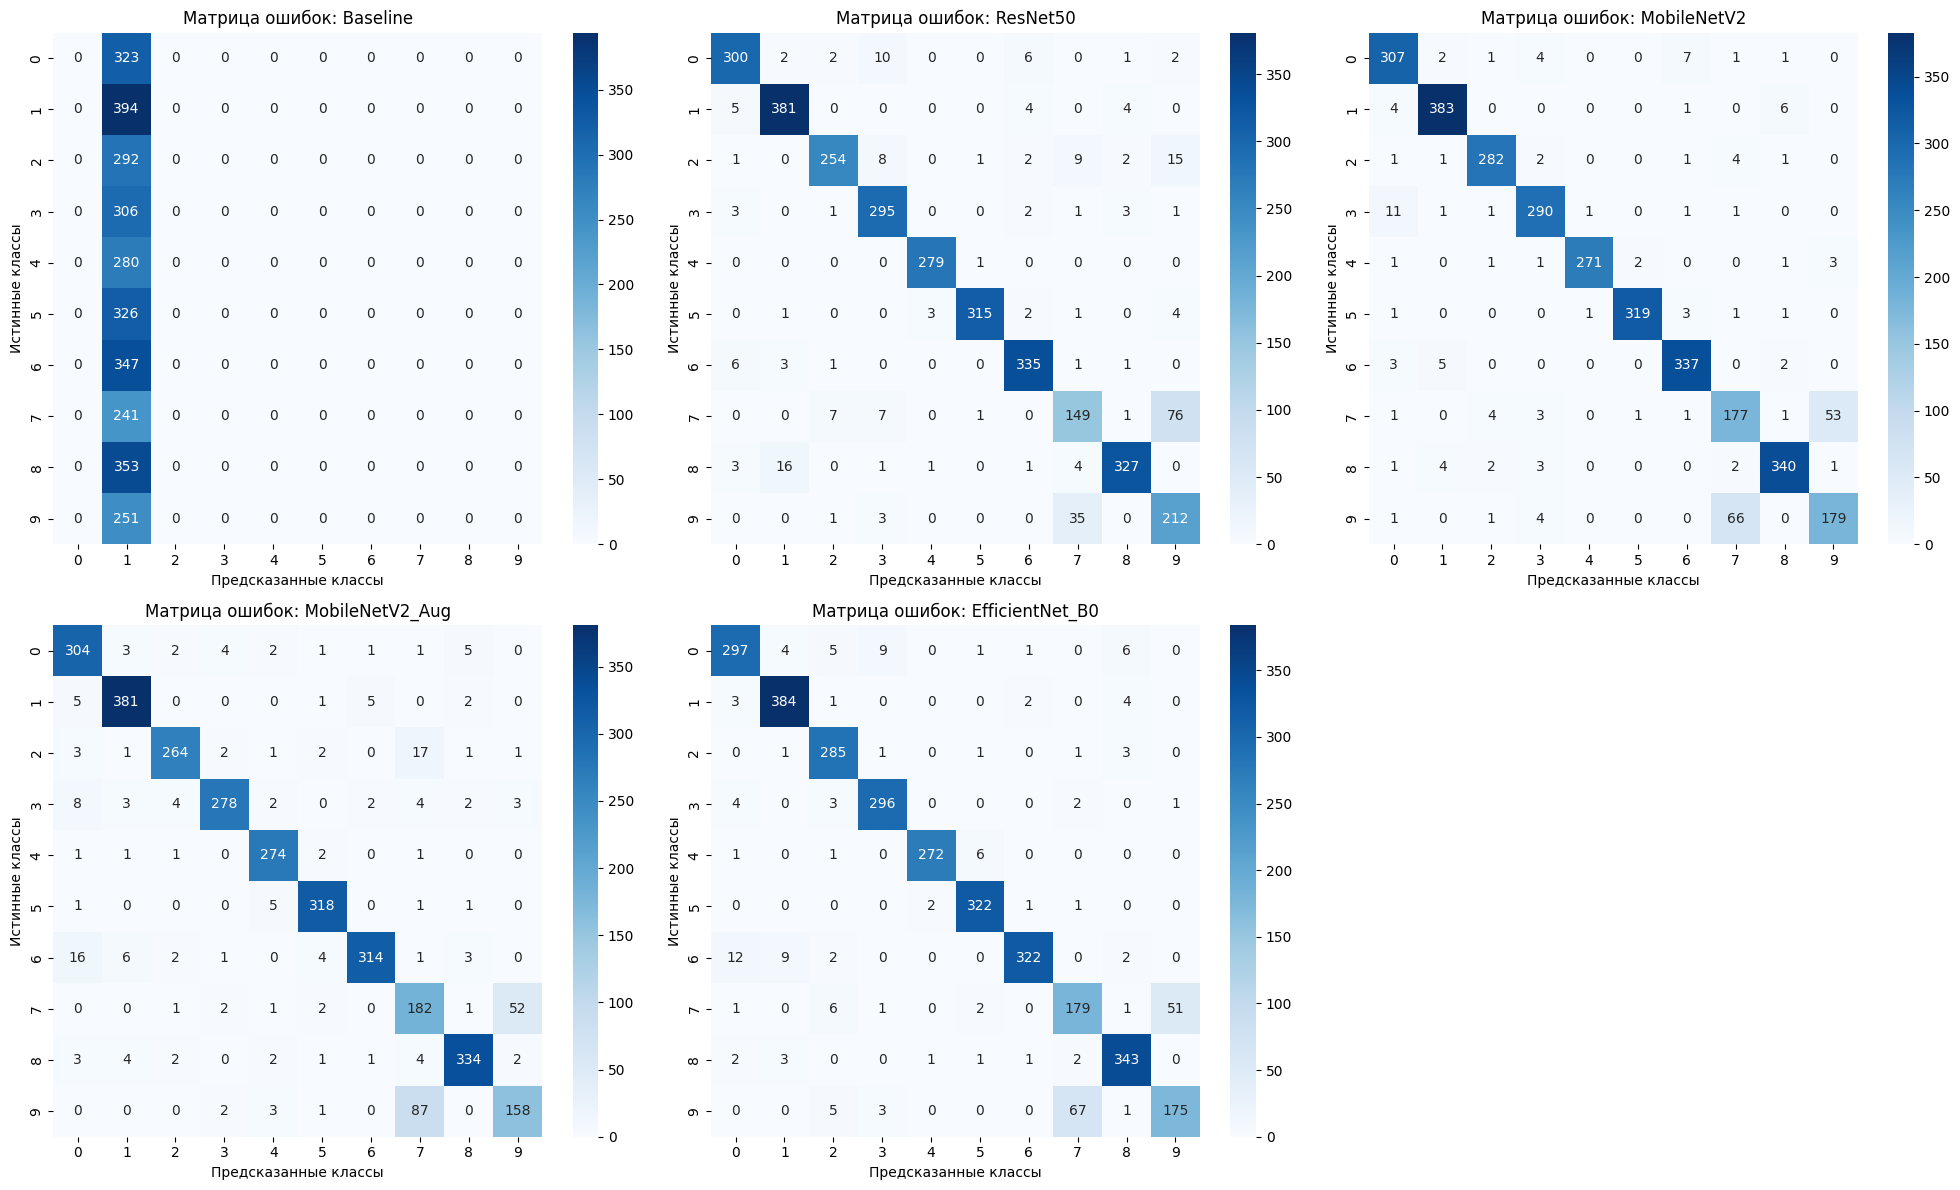

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_val_preds(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# Получаем список имен классов
class_names = full_dataset_aug.classes

# Визуализация
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for i, (name, model) in enumerate(all_models.items()):
    y_true, y_pred = get_val_preds(model, val_loader_aug)
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=class_names, yticklabels=class_names)
    axes[i].set_title(f'Матрица ошибок: {name}')
    axes[i].set_ylabel('Истинные классы')
    axes[i].set_xlabel('Предсказанные классы')

# Удаляем пустой 6-й подграфик, если моделей всего 5
if len(all_models) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

Все модели путают 7 и 9 классы. 

Выведем примеры этих классов.

Поиск: Истина = 7, Предсказано = 9


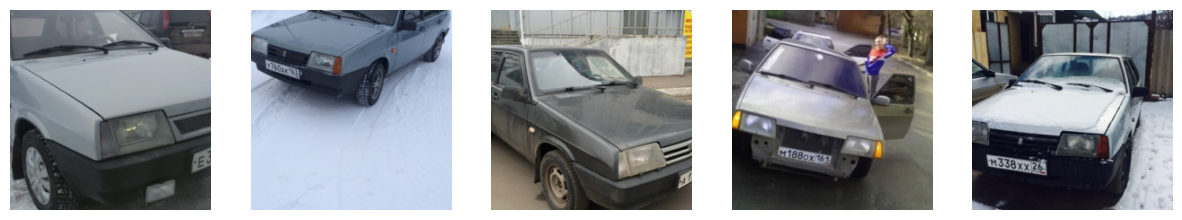

Поиск: Истина = 9, Предсказано = 7


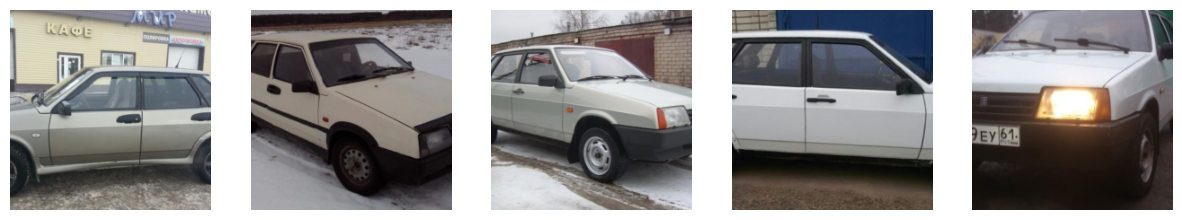

In [34]:
def show_misclassified_images(model, loader, target_class, predicted_class, num_images=5):
    model.eval()
    found_images = []
    
    # Инвертируем словарь классов, чтобы получить названия по индексам
    idx_to_class = {v: k for k, v in full_dataset_aug.class_to_idx.items()}
    
    print(f"Поиск: Истина = {idx_to_class[target_class]}, Предсказано = {idx_to_class[predicted_class]}")
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Ищем индексы, где произошла конкретная ошибка
            mask = (labels == target_class) & (preds == predicted_class)
            if mask.any():
                imgs = inputs[mask].cpu()
                found_images.extend(imgs)
            
            if len(found_images) >= num_images:
                break

    # Визуализация найденных ошибок
    plt.figure(figsize=(15, 5))
    for i in range(min(len(found_images), num_images)):
        plt.subplot(1, num_images, i + 1)
        img = found_images[i].permute(1, 2, 0).numpy()
        # Денормализация для корректного отображения
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Запускаем для лучшей модели (EfficientNet)
# Проверим путаницу 7 -> 9
show_misclassified_images(model_effnet, val_loader_aug, target_class=7, predicted_class=9)
# И наоборот 9 -> 7
show_misclassified_images(model_effnet, val_loader_aug, target_class=9, predicted_class=7)

Одна и та же модель вроде.

### Шаг 8: Сохранение моделей

In [35]:
import torch
import os

# Создаем папку для моделей, если её нет
os.makedirs('models_zoo', exist_ok=True)

# Список всех наших моделей
models_to_save = {
    'baseline': model_baseline,
    'resnet50': model_resnet,
    'mobilenet_v2': model_mobilenet,
    'mobilenet_v2_aug': model_mobile_aug,
    'efficientnet_b0': model_effnet
}

print("--- Сохранение моделей ---")
for name, model in models_to_save.items():
    path = f'models_zoo/{name}_cars.pth'
    torch.save(model.state_dict(), path)
    print(f"Модель {name} сохранена в: {path}")

print("\nВсе модели успешно упакованы!")

--- Сохранение моделей ---
Модель baseline сохранена в: models_zoo/baseline_cars.pth
Модель resnet50 сохранена в: models_zoo/resnet50_cars.pth
Модель mobilenet_v2 сохранена в: models_zoo/mobilenet_v2_cars.pth
Модель mobilenet_v2_aug сохранена в: models_zoo/mobilenet_v2_aug_cars.pth
Модель efficientnet_b0 сохранена в: models_zoo/efficientnet_b0_cars.pth

Все модели успешно упакованы!


In [36]:
import shutil

# Путь к папке, которую хотим запаковать
source_dir = 'models_zoo'
# Название и формат архива
output_filename = 'trained_car_models'

# Создаем zip-архив
shutil.make_archive(output_filename, 'zip', source_dir)

print(f"Архив {output_filename}.zip успешно создан!")

Архив trained_car_models.zip успешно создан!


### Шаг 8: Использование модели

In [37]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# 1. Воссоздаем архитектуру (должна быть идентична той, что обучали)
model = models.resnet50(weights=None) # weights=None, так как загружаем свои
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10) # 10 — количество твоих классов

# 2. Загружаем сохраненные веса из архива
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('models_zoo/resnet50_cars.pth', map_location=device))
model.to(device)
model.eval() # Обязательно переводим в режим оценки

# 3. Подготовка изображения (те же трансформации, что на валидации)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def predict_car(image_path, model, class_names):
    img = Image.open(image_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0).to(device) # Добавляем размер батча
    
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf, pred = torch.max(probs, 1)
        
    return class_names[pred.item()], conf.item()

In [45]:
class_names = ['0', 'Ford', 'Lada 9', 'Lada 3', 'Lada 7',  'Niva', 'Lada Kalina', 'Lada 7', 'VW', 'Lada 99'] 
label, score = predict_car('/kaggle/input/datasets/aivauzun/data-lake/train/train/8/100578.jpg', model, class_names)
print(f"Предсказание: {label} ({score:.2%})")

Предсказание: VW (100.00%)


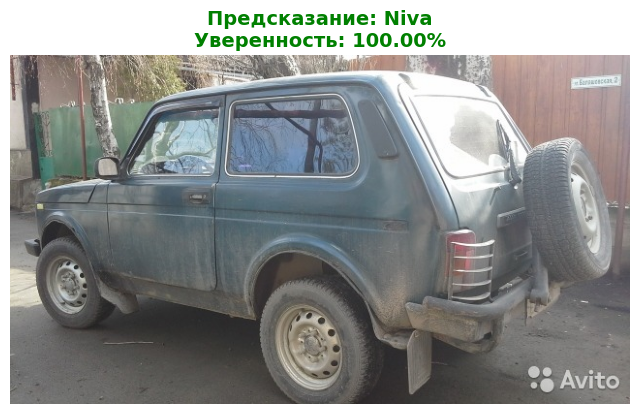

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def predict_and_show(image_path, model, class_names):
    # 1. Загрузка и предобработка
    img_orig = Image.open(image_path).convert('RGB')
    img_tensor = preprocess(img_orig).unsqueeze(0).to(device)
    
    # 2. Инференс
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf, pred = torch.max(probs, 1)
        
    label = class_names[pred.item()]
    score = conf.item()

    # 3. Визуализация
    plt.figure(figsize=(8, 5))
    plt.imshow(img_orig)
    
    # Цветовая индикация: зеленый если уверенность > 80%, иначе оранжевый
    title_color = 'green' if score > 0.8 else 'orange'
    
    plt.title(f"Предсказание: {label}\nУверенность: {score:.2%}", 
              fontsize=14, color=title_color, fontweight='bold')
    plt.axis('off')
    plt.show()

# Использование
class_names = class_names #full_dataset_aug.classes 
img_path = '/kaggle/input/datasets/aivauzun/data-lake/train/train/5/100555.jpg'

predict_and_show(img_path, model, class_names)